In [1]:
import os
import numpy as np
import cv2 as cv
from scipy import signal
from scipy.signal import butter, lfilter

In [3]:
import sys
import autoreload
from Frames_Alignment import *
from ROI_Signal_Visualization import *
%load_ext autoreload
%autoreload 2

## 获取所有视频文件路径，两个数据集VIPL-HR以及BEAN-HR中选择一种即可
## VIPL-HR数据集的申请参考[中科院官网](https://vipl.ict.ac.cn/view_database.php?id=15)
## BEAN-HR暂时不对外开放下载

In [7]:
def get_all_video_path_BEAN(root_dir):
    all_video_path = []
    for dirpath,_,filenames in os.walk(root_dir):
        for file in filenames:
            all_video_path.append(os.path.join(dirpath,file))

    return all_video_path

def get_all_video_path_VIPL(root_dir,scenario=['v1']):
    #  测试者分组的路径
    people_grouped_path = [os.path.join(root_dir,name) for name in os.listdir(root_dir) if 'zip' not in name]
    num_grouped = len(people_grouped_path)

    #  单个测试者的路径
    person_path = []
    for group in people_grouped_path:
        person_path.extend([os.path.join(group,name) for name in os.listdir(group)])
    num_person = len(person_path)

    #  所有场景的路径
    scenario_path = []
    for person in person_path:
        scenario_path.extend([os.path.join(person,name) for name in os.listdir(person)])
    
    target_scenario_path = [path for path in scenario_path if os.path.basename(path) in scenario]
    
    video_path = []
    for path in target_scenario_path:
        video_path.append(os.path.join(os.path.join(path,"source2"),"video.avi"))
    
    return video_path

#  VIPL-HR数据集
# root_dir = "D:\BaiduNetdiskDownload\VIPL-HR\data"
# all_video_path = get_all_video_path_VIPL(root_dir,scenario=['v1','v3','v4','v5','v6','v7','v8'])

#  BEAN-HR数据集
root_dir = "D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1"
all_video_path = get_all_video_path_BEAN(root_dir)

In [9]:
print(all_video_path[:10])

['D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\1.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\10.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\11.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\12.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\13.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\14.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\15.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\16.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\17.MOV', 'D:\\BaiduNetdiskDownload\\ECNU-Dataset-AVC1\\18.MOV']


## 获取视频文件基础信息

In [19]:
def get_video_length(video_path):
    """
        给入视频路径，计算视频的长度以及FPS

        return:
        video_length:视频的长度，单位：s
        fps_counter：视频的帧率
    """
    video_capture = cv2.VideoCapture(video_path)

    frame_counter = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_counter = video_capture.get(cv2.CAP_PROP_FPS)
    video_length = frame_counter/fps_counter

    video_capture.release()
    
    return video_length,fps_counter

def size_convert(size):
    """
       文件大小单位换算,输入size为文件字节数
    """
    K, M, G = 1024, 1024 ** 2, 1024 ** 3
    if size >= G:
        return str(round((size / G), 2)) + ' GB'
    elif size >= M:
        return str(round((size / M), 2)) + ' MB'
    elif size >= K:
        return str(round((size / K), 2)) + ' K'
    else:
        return str(round((size), 3)) + ' B'

def get_video_size(video_path):
    file_byte = os.path.getsize(video_path)
    
    return size_convert(file_byte)

## 视频分段信息获取，本项目将视频分成等长的片段，方便一起送入神经网络训练

In [11]:
def video_crop_info(video_length,fps,crop_length):
    """
        计算视频分割的信息，给出所选片段的开头帧和结尾帧

        params:
        video_length:视频的长度，单位：s
        fps：视频的帧速率，单位：帧每秒
        crop_length:每个分割片段的长度，单位：s

        return:
        start_frame:开始帧位置的列表[start1,start2,...]
        stop_frame:结束帧位置的列表[stop1,stop2,...]
    """
    if crop_length != None:
        num = int(video_length // crop_length)   #  片段数目
        start_frame = [int(np.round((video_length - crop_length * num) * fps / 2 + i * crop_length * fps)) for i in range(num)]
        stop_frame = (np.array(start_frame) + 250).astype(np.int32).tolist()
    else:
        start_frame = [0]
        stop_frame = (np.array(start_frame) + fps * video_length).astype(np.int32).tolist()
    
    return start_frame,stop_frame

## 读取ROI像素平均值1D信号，并缓存

In [12]:
def yield_frames_of_clipped_video(video_file,batch_size,min_size,start,stop,resize=False):
    """
        从视频文件读取一定数量的帧，存放在一个列表中，元素为np.ndarray

        params:
        video_file:视频文件路径列表
        batch_size:一批的数量
        min_size:读入的图像最短边缩放到多长
        start:clip开始的帧
        stop:clip结束的帧
    """
    video_capture = cv2.VideoCapture(video_file)
    frame_idx = 0
    batch_idx = 0

    while True:
        frames = []
        while video_capture.isOpened():
            while batch_idx < batch_size:
                ret, frame = video_capture.read()
                #  读到视频结尾的话，退出循环
                if not ret:
                    video_capture.release()
                    break
                if frame_idx >= start:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    if resize == True:
                        scaled_shape = get_scaled_wh(frame.shape[:2],min_size)
                        frame = cv2.resize(frame,scaled_shape[::-1],interpolation=cv2.INTER_LINEAR)
                    frames.append(frame)

                    batch_idx += 1
                frame_idx += 1
                if frame_idx == stop:
                    video_capture.release()
                    break 
            batch_idx = 0
            break
        yield frames

def video2ROI(file,batch_size,cmap,resize,remove_skin,min_size,span,w_density,h_density,ROI_ids,save_root_path,start,stop):
    """
        从视频文件中提取1D信号并保存在文件中的整个pipeline

        params:
        file:视频文件路径
        batch_size:批量处理的帧数目，此电脑显存不大，所以别超过20
        cmap:颜色通道
        resize:是否缩放图片
        min_size:把图片缩放到最短边的边长为min_size
        span:高斯滤波消抖的跨度，越大越平滑
        w_density:ROI纵向分割的密度
        h_density:ROI横向分割的密度
        ROI_ids:list，要读取的ROI序号，指标从0开始
        start:clip开始的帧
        stop:clip结束的帧
    """
    # 帧生成器
    frames_gen = yield_frames_of_clipped_video(file,batch_size,min_size,start,stop,resize)
    
    while True:
        frames = next(frames_gen)
        #  如果没有帧，则直接结束
        if len(frames) == 0:
            break
        
        #  获取帧中的人脸位置及关键点坐标
        batch_of_face_locations,batch_of_landmarks,num_chin,num_eye = get_location_landmark(frames,0)
        
        #  如果在当前clip中有一帧没找到人脸，那么这个clip就不做处理
        if num_chin == None and num_eye == None:
            return False
        
        #  关键点滤波
        batch_of_filtered_landmarks = landmarks_filter(batch_of_landmarks,span)
        frames = np.array(frames)
        
        #  旋转帧使人脸水平
        rotated_frames, eye_centers, angles = rotate_face(frames, batch_of_filtered_landmarks, num_chin, num_eye)
        
        #  旋转关键点
        rotated_landmarks = rotate_landmarks(eye_centers, batch_of_filtered_landmarks, angles)
        
        #  把人脸剪裁出来
        cropped_frames,lefts,tops = crop_face(rotated_frames, eye_centers, rotated_landmarks)
        
        #  关键点坐标变换
        transferred_landmarks = transfer_landmark(rotated_landmarks, lefts, tops)
        
        #  去除非皮肤区域
        if remove_skin:
            skin_frames,skin_masks = extract_Skin_YCrCb_Otsu(cropped_frames)
        else:
            skin_frames = cropped_frames
        
        #  颜色通道转换/提取
        if cmap.lower() == 'green':
            skin_frames = RGB2G(skin_frames)
        elif cmap.lower() == 'yuv':
            skin_frames = RGB2YUV(skin_frames)
        elif cmap.lower() == 'rgb':
            pass

        signal_1D = channel_1D_signal(skin_frames,w_density,h_density,ROI_ids)  #  shape:batch_size*n_ROI*n_channel
        
        save_signal(save_root_path,signal_1D,ROI_ids,cmap)
        
        #  如果frames长度不足batch_size，说明视频读完了
        if len(frames) != batch_size:
            break
        
    return True

def cache_signal_VIPL(video_path,cache_root_dir,crop_length=10):
    """
       遍历视频，缓存视频片段1D信号
       
       params:
       video_path:视频绝对路径列表
       cache_root_dir:缓存目录
       crop_length:视频片段截取的长度,如果是None，则整个视频都要
    """
    for path in video_path:
        person_id,scene_id = path.split("\\")[-4],path.split("\\")[-3]
        person_root_dir = os.path.join(cache_root_dir,person_id)
        scene_root_dir = os.path.join(person_root_dir,scene_id)
        #  创建目录
        if not os.path.exists(person_root_dir):
            os.mkdir(person_root_dir)
        if not os.path.exists(scene_root_dir):
            os.mkdir(scene_root_dir)
        
        video_length,fps = get_video_length(path)
        start_frame,stop_frame = video_crop_info(video_length,fps,crop_length)
        
        for idx,start,stop in zip(range(1,len(start_frame)+1),start_frame,stop_frame):
            if not os.path.exists(scene_root_dir):
                os.mkdir(scene_root_dir)
            
            save_root_path = os.path.join(scene_root_dir,"clip{}".format(idx))
            if not os.path.exists(save_root_path):
                os.mkdir(save_root_path)
            
            clip_valid = video2ROI(path,batch_size,cmap,resize,remove_skin,min_size,span,w_density,h_density,ROI_ids,save_root_path,start,stop)
            
            #  如果clip无效，即出现未检测出人脸的帧，则需要把当前clip文件夹删除
            if not clip_valid:
                for dirpath, dirnames, filenames in os.walk(save_root_path):
                    for file in filenames:
                        file_abspath = os.path.join(dirpath,file)
                        os.remove(file_abspath)
                    os.removedirs(dirpath)
                print("Clip {} of video {} is not considered because of non-face-detected frames.".format(idx,path))
                continue
            
        print("Video {} cached successfully!".format(path))

def cache_signal_ECNU(video_path,cache_root_dir,crop_length=10):
    """
       遍历视频，缓存视频片段1D信号
       
       params:
       video_path:视频绝对路径列表
       cache_root_dir:缓存目录
       crop_length:视频片段截取的长度,如果是None，则整个视频都要
    """
    for path in video_path:
        person_id = os.path.basename(path).split('.')[0]
        person_root_dir = os.path.join(cache_root_dir,person_id)
        #  创建目录
        if not os.path.exists(person_root_dir):
            os.mkdir(person_root_dir)
        
        video_length,fps = get_video_length(path)
        start_frame,stop_frame = video_crop_info(video_length,fps,crop_length)
        
        for idx,start,stop in zip(range(1,len(start_frame)+1),start_frame,stop_frame):
            if not os.path.exists(person_root_dir):
                os.mkdir(person_root_dir)
            
            save_root_path = os.path.join(person_root_dir,"clip{}".format(idx))
            if not os.path.exists(save_root_path):
                os.mkdir(save_root_path)
            
            clip_valid = video2ROI(path,batch_size,cmap,resize,remove_skin,min_size,span,w_density,h_density,ROI_ids,save_root_path,start,stop)
            
            #  如果clip无效，即出现未检测出人脸的帧，则需要把当前clip文件夹删除
            if not clip_valid:
                for dirpath, dirnames, filenames in os.walk(save_root_path):
                    for file in filenames:
                        file_abspath = os.path.join(dirpath,file)
                        os.remove(file_abspath)
                    os.removedirs(dirpath)
                print("Clip {} of video {} is not considered because of non-face-detected frames.".format(idx,path))
                continue
            
        print("Video {} cached successfully!".format(path))

### 先设置必须的参量

In [35]:
batch_size = 10
cmap = 'RGB'
resize = False
remove_skin = True
min_size = 1000
span = 10
w_density = 7
h_density = 4
ROI_ids = list(range(w_density*h_density))
root_dir = "D:\BaiduNetdiskDownload\ECNU-Dataset-WMV3"
cache_root_dir = "./cache/origin/ECNU-Dataset-WMV3-cache-total-span{}".format(span)
cached_already = False

if not os.path.exists(cache_root_dir):
    os.makedirs(cache_root_dir)
else:
    cached_already = True

In [13]:
length,fps = get_video_length(all_video_path[0])
print(length,fps)

59.82 29.973253092611166


### 视频平均大小

In [27]:
files_size_str = []
for path in all_video_path:
    files_size_str.append(get_video_size(path))

files_size_num = [float(size.split(" ")[0]) for size in files_size_str]
print("Average size of video is {:.2f} {}.".format(np.mean(files_size_num),files_size_str[0].split(' ')[1]))

Average size of video is 147.82 MB.


### 开始缓存提取出的像素平均值信号

In [37]:
if not cached_already:
#     cache_signal_VIPL(all_video_path,cache_root_dir,crop_length=None)
    cache_signal_ECNU(all_video_path,cache_root_dir,crop_length=None)
else:
    print("Already cached.")

Already cached.


## 信号带通滤波并缓存

In [54]:
def filter_cached_signal_VIPL(cache_root_dir,filtered_root_dir,fps,scene='v1',mode='train'):
    """
       把缓存好的文件中的数据进行带通滤波,并缓存到新的路径下
       
       params:
       cache_root_dir：缓存好的1D信号的根目录
       filtered_root_dir：保存滤波后信号的根目录
       scene：场景选择
       mode：指定训练还是推理模式,train/inference
    """
    
    for dirpath, dirnames, filenames in os.walk(cache_root_dir):
        if mode == "train":
            if dirpath.split("\\")[-2] == scene:
                for file in filenames:
                    signal_file = os.path.join(dirpath, file)
                    
                    save_file_path = os.path.join(filtered_root_dir,signal_file[signal_file.find('\\p') + 1:])
                    if not os.path.exists(os.path.dirname(save_file_path)):
                        os.makedirs(os.path.dirname(save_file_path))
                    elif os.path.exists(save_file_path):
                        continue
                    
                    with open(signal_file,'r') as f:
                        data = [float(l) for l in f.read().split()]

                    #  [0.67,4]/25(fps) = [0.027,0.16]
                    frequency_range = (np.array([0.67,4]) / fps).tolist()
                    b_band, a_band = signal.butter(8, frequency_range, 'bandpass')   #配置滤波器, 8表示滤波器的阶数
                    filtered_data = signal.filtfilt(b_band, a_band, data, axis=-1)  #data为要过滤的信号

                    with open(save_file_path,'w') as f:
                        save_data = [str(d) for d in filtered_data]
                        f.write(' '.join(save_data))
        elif mode == "inference":
            for file in filenames:
                signal_file = os.path.join(dirpath, file)

                save_file_path = os.path.join(filtered_root_dir,"\\".join(signal_file.split("\\")[-3:]))
                if not os.path.exists(os.path.dirname(save_file_path)):
                    os.makedirs(os.path.dirname(save_file_path))
                elif os.path.exists(save_file_path):
                    continue
                
                with open(signal_file,'r') as f:
                    data = [float(l) for l in f.read().split()]

                #  [0.67,4]/25(fps) = [0.027,0.16]
                frequency_range = (np.array([0.67,4]) / fps).tolist()
                b_band, a_band = signal.butter(8, frequency_range, 'bandpass')   #配置滤波器, 8表示滤波器的阶数
                filtered_data = signal.filtfilt(b_band, a_band, data, axis=-1)  #data为要过滤的信号

                with open(save_file_path,'w') as f:
                    save_data = [str(d) for d in filtered_data]
                    f.write(' '.join(save_data))
                        
def filter_cached_signal_ECNU(cache_root_dir,filtered_root_dir,fps):
    """
       把缓存好的文件中的数据进行带通滤波,并缓存到新的路径下
       cache_root_dir：缓存好的1D信号的根目录
       filtered_root_dir：保存滤波后信号的根目录
    """
    for dirpath, dirnames, filenames in os.walk(cache_root_dir):
        for file in filenames:
            signal_file = os.path.join(dirpath, file)
            
            save_file_path = os.path.join(filtered_root_dir,"\\".join(signal_file.split("\\")[-3:]))
            if not os.path.exists(os.path.dirname(save_file_path)):
                os.makedirs(os.path.dirname(save_file_path))
            elif os.path.exists(save_file_path):
                continue
            
            with open(signal_file,'r') as f:
                data = [float(l) for l in f.read().split()]

            #  [0.67,4] * 2 / 25(fps) = [0.054,0.32]
            frequency_range = (np.array([0.67,4]) * 2 / fps).tolist()
            b_band, a_band = signal.butter(8, frequency_range, 'bandpass')   #配置滤波器, 8表示滤波器的阶数
            filtered_data = signal.filtfilt(b_band, a_band, data, axis=-1)   #data为要过滤的信号
            
            with open(save_file_path,'w') as f:
                save_data = [str(d) for d in filtered_data]
                f.write(' '.join(save_data))
                    
def show_signal(data,title=None):
    """
      可视化信号
    """
    plt.figure(figsize=(10, 5))
    
    plt.xlabel("Time/s")
    plt.title(title)

    #  设置坐标轴刻度及范围
    xticks = np.round(np.arange(0,len(data)/fps+0.001,len(data)/fps/10),2)
    plt.xticks(xticks)
    plt.xlim([0,len(data)/fps])

    yticks = np.arange(min(data)-5,max(data)+5,(max(data)-min(data)+10)/10)
    plt.yticks(yticks)
    plt.ylim([min(data)-5,max(data)+5])

    x = np.round(np.arange(0,len(data),1) / fps,2)
    plt.plot(x,data,"g-")
    plt.grid(True)

In [55]:
filtered_root_dir = "./cache/filtered/ECNU-Dataset-WMV3-cache-filtered-span{}".format(span)

filter_cached_signal_ECNU(cache_root_dir,filtered_root_dir,fps)

## 可视化滤波后的信号

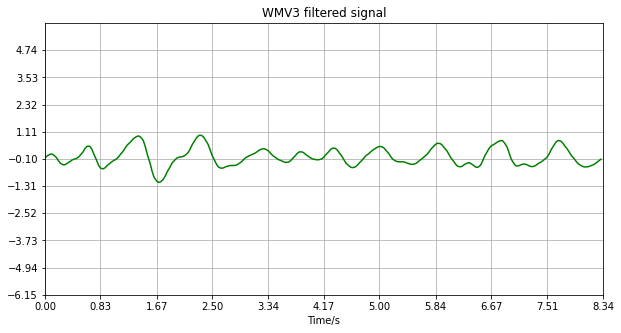

In [41]:
with open("./cache/filtered/ECNU-Dataset-WMV3-cache-filtered-span10\\1\\clip1\\channel_G_ROI_8.txt",'r') as f:
    data_WMV3 = [float(l) for l in f.read().split()]

show_signal(data_WMV3[-250:],title='WMV3 filtered signal')